<a href="https://colab.research.google.com/github/anu04596/DeepLearningTuotorial/blob/main/Day18(CAM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Grad-CAM = Gradient-weighted Class Activation Map

Import Libraries

In [76]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

 Load Image

In [77]:
img_path='/content/dog.jpeg'
image=Image.open(img_path).convert('RGB')

In [78]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

input_tensor = preprocess(image).unsqueeze(0)

Load Pretrained ResNet18

In [79]:
model = models.resnet18(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Activations and gradients Hooks

In [80]:
features = []
gradients = []

In [81]:
def forward_hook(module, input, output):
    features.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

In [82]:
target_layer = model.layer4[-1].conv2
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

Forward Pass

In [83]:
output=model(input_tensor)
pred_class=output.argmax().item()
print(f"Predicted class index: {pred_class}")

Predicted class index: 208


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [90]:
import json
import urllib.request

# Download ImageNet class index
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
class_names = []
with urllib.request.urlopen(url) as f:
    class_names = [line.strip().decode('utf-8') for line in f.readlines()]

# Print predicted label
print("Predicted Class:", class_names[pred_class])

Predicted Class: Labrador retriever


Backpropogate

In [84]:
model.zero_grad()
class_loss = output[0, pred_class]
class_loss.backward()

Heatmap

In [85]:
grads = gradients[0].mean(dim=(2, 3), keepdim=True)
cam = (features[0] * grads).sum(dim=1)[0]
cam = F.relu(cam)

In [86]:
cam -= cam.min()
cam /= cam.max()
cam = cam.detach().numpy()

In [87]:
cam = cv2.resize(cam, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

In [88]:
img_np = np.array(image.resize((224, 224)))
superimposed = cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0)

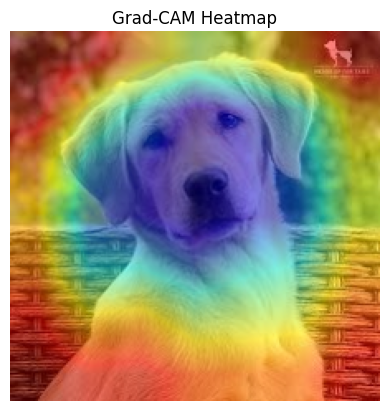

In [89]:
plt.imshow(superimposed)
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()